Imports

In [2]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from itertools import product as cartesian_prod
import random
from scipy import spatial

Constants and Hyperparameters

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

device(type='cpu')

In [4]:
# Use the Negative Log Likelihood Loss function on the outputs after log_softmax activation
lossFn = nn.NLLLoss()

In [5]:
args={}
kwargs={}

args['input_size'] = 784  #Number of features in the input image(of size 28x28)
args['depth'] = 4  #Number of layers in the neural network
args['width']=64  #Number of neurons in each hidden layer
args['batch_size']=32  #Number of samples in each batch
args['epochs']=30  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=5e-5  #Learning rate is how fast it will decend. 
args['eps']=1e-7  #Epsilon value for Adam
args['classes']=10

args['cuda']=True  #Use GPU or not

In [6]:
eps, beta = 0.1, 4

Load the dataset

In [7]:
#load the train data and validation data, and normalize it

mnist_transforms=[
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
     ]

train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)

validation_loader = DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose(mnist_transforms)),
    batch_size=args['batch_size'], shuffle=True, **kwargs)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



Train and validation functions

In [ ]:
def train(model, epoch, train_loader, lossFn, optimizer):
  model.train()
  loss = 0
  net_loss = 0
  correct = 0
  
  for batch_idx, (data, target) in enumerate(train_loader):
      # if args['cuda']:
      #     data, target = data.cuda(), target.cuda()
      
      #Reshape the input image to 1D vector
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)

      #This will zero out the gradients for this batch. 
      optimizer.zero_grad()

      #Run the model on the train data
      _, output = model(data)
      
      # Calculate the loss
      loss = lossFn(output, target)
      net_loss += loss.data

      #dloss/dx for every Variable 
      loss.backward()

      #to do a one-step update on our parameter.
      optimizer.step()

      pred = output.data.max(1, keepdim=True)[1]  #get the index of the max log-probability which is the predicted class

      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

      
  #Print out the loss
  print('Train Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss/len(train_loader.dataset), correct, len(train_loader.dataset),
      100. * correct / len(train_loader.dataset)))

def validate(model, validation_loader, lossFn):

  model.eval()
  validation_loss = 0
  correct = 0

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data, target in validation_loader:
      # if args['cuda']:
      #     data, target = data.cuda(), target.cuda()

      #Reshape the input image to 1D vector
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)

      #Run the model on the validation data and get its predictions
      _, output = model(data)

      #Calculate the loss
      validation_loss += lossFn(output, target).data.item()  #sum up batch loss

      pred = output.data.max(1, keepdim=True)[1]  #get the index of the max log-probability which is the predicted class

      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()  #find the number of correct predictions

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      validation_loss/len(validation_loader.dataset), correct, len(validation_loader.dataset),
      100. * correct / len(validation_loader.dataset)))

DLGN 

In [8]:
#Class implementing the soft ReLU activation function
class SoftGate(nn.Module):
    def __init__(self, **kwargs):
        super(SoftGate, self).__init__()

    def build(self, input_shape):
        super(SoftGate, self).build(input_shape)  

    def forward(self, x):
        activation = (1 + eps)*torch.sigmoid(beta*x)
        return activation

    def compute_output_shape(self, input_shape):
        return input_shape


In [9]:
class GaluConstantNPVWithNPFBias(nn.Module):
  def __init__(self, depth, width, classes, input_size):

    super(GaluConstantNPVWithNPFBias, self).__init__()

    self.depth = depth
    self.width = width

    setattr(self,'NPF_L1', nn.Linear(input_size, width))  #NPF network's layer 1

    setattr(self,'NPV_L1', nn.Linear(input_size, width, bias=False))

    for i in range(depth - 2):
      setattr(self,'NPF_L{}'.format(i+2), nn.Linear(width, width))

      setattr(self,'NPV_L{}'.format(i+2), nn.Linear(width, width, bias=False))

    setattr(self,'NPV_L{}'.format(depth), nn.Linear(width, classes, bias=False))
      
  def forward(self, x):
    Zf = getattr(self,'NPF_L1')(x)  #Linear activations(So Qf = Zf) of layer 1 of NPF network
    G = SoftGate()(Zf)  #Gating values

    Qv = getattr(self,'NPV_L1')(torch.Tensor(np.ones(x.shape)).to(device))  #Pre-activations of layer 1 of NPV network with constant input
    Zv = torch.mul(G, Qv)  #Gating value(from NPF) times Pre-Activations of layer 1 of NPV network is the Activations for layer 1 of NPV network

    # Repeat the above computations for all the hidden layers
    for i in range(self.depth-2):
      Zf = getattr(self,'NPF_L{}'.format(i+2))(Zf)
      G = SoftGate()(Zf)

      Qv = getattr(self,'NPV_L{}'.format(i+2))(Zv)
      Zv = torch.mul(G, Qv)

    Q_out = getattr(self,'NPV_L{}'.format(self.depth))(Zv)
    Z_out = F.log_softmax(Q_out)

    return Q_out, Z_out

In [ ]:
decoupled_const_NPV_model_with_NPF_bias = GaluConstantNPVWithNPFBias(args['depth'], args['width'], args['classes'], args['input_size'])
print(decoupled_const_NPV_model_with_NPF_bias)
print()

GaluConstantNPVWithNPFBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)



In [ ]:
# if args['cuda']:
#     decoupled_const_NPV_model_with_NPF_bias = decoupled_const_NPV_model_with_NPF_bias.cuda()
#     lossFn = lossFn.cuda()

decoupled_const_NPV_model_with_NPF_bias = decoupled_const_NPV_model_with_NPF_bias.to(device)
lossFn = lossFn.to(device)

optimizer = optim.Adam(decoupled_const_NPV_model_with_NPF_bias.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(decoupled_const_NPV_model_with_NPF_bias, epoch, train_loader, lossFn, optimizer)
    validate(decoupled_const_NPV_model_with_NPF_bias, validation_loader, lossFn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 	Loss: 0.013947, Accuracy: 52276/60000 (87%)

Validation set: Average loss: 0.0071, Accuracy: 9308/10000 (93%)

Train Epoch: 2 	Loss: 0.006101, Accuracy: 56462/60000 (94%)

Validation set: Average loss: 0.0055, Accuracy: 9468/10000 (95%)

Train Epoch: 3 	Loss: 0.004776, Accuracy: 57229/60000 (95%)

Validation set: Average loss: 0.0048, Accuracy: 9532/10000 (95%)

Train Epoch: 4 	Loss: 0.003956, Accuracy: 57700/60000 (96%)

Validation set: Average loss: 0.0041, Accuracy: 9583/10000 (96%)

Train Epoch: 5 	Loss: 0.003384, Accuracy: 57973/60000 (97%)

Validation set: Average loss: 0.0041, Accuracy: 9604/10000 (96%)

Train Epoch: 6 	Loss: 0.002928, Accuracy: 58275/60000 (97%)

Validation set: Average loss: 0.0037, Accuracy: 9644/10000 (96%)

Train Epoch: 7 	Loss: 0.002569, Accuracy: 58486/60000 (97%)

Validation set: Average loss: 0.0036, Accuracy: 9652/10000 (97%)

Train Epoch: 8 	Loss: 0.002264, Accuracy: 58660/60000 (98%)

Validation set: Average loss: 0.0036, Accuracy: 96

In [ ]:
for name,params in decoupled_const_NPV_model_with_NPF_bias.named_parameters():
  print(f"{name} \t {params.shape}")

NPF_L1.weight 	 torch.Size([64, 784])
NPF_L1.bias 	 torch.Size([64])
NPV_L1.weight 	 torch.Size([64, 784])
NPF_L2.weight 	 torch.Size([64, 64])
NPF_L2.bias 	 torch.Size([64])
NPV_L2.weight 	 torch.Size([64, 64])
NPF_L3.weight 	 torch.Size([64, 64])
NPF_L3.bias 	 torch.Size([64])
NPV_L3.weight 	 torch.Size([64, 64])
NPV_L4.weight 	 torch.Size([10, 64])


Store weights of all layers

In [ ]:
torch.save(decoupled_const_NPV_model_with_NPF_bias.state_dict(), './Constant NPV Model With Bias for NPF')

Load the model

In [10]:
decoupled_const_NPV_model_with_NPF_bias = GaluConstantNPVWithNPFBias(args['depth'], args['width'], args['classes'], args['input_size'])
decoupled_const_NPV_model_with_NPF_bias.load_state_dict(torch.load('./Constant NPV Model With Bias for NPF'))
decoupled_const_NPV_model_with_NPF_bias.eval()

GaluConstantNPVWithNPFBias(
  (NPF_L1): Linear(in_features=784, out_features=64, bias=True)
  (NPV_L1): Linear(in_features=784, out_features=64, bias=False)
  (NPF_L2): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L2): Linear(in_features=64, out_features=64, bias=False)
  (NPF_L3): Linear(in_features=64, out_features=64, bias=True)
  (NPV_L3): Linear(in_features=64, out_features=64, bias=False)
  (NPV_L4): Linear(in_features=64, out_features=10, bias=False)
)

Function to get the weights of NPV network

In [11]:
def get_params(model, str, bias=False):
  weights = []
  biases = []

  for i in range(args['depth']):
    layer_weight = model.state_dict()[str+'_L{}.weight'.format(i+1)]
    weights.append(layer_weight)

    if bias:
      layer_bias = model.state_dict()[str+'_L{}.bias'.format(i+1)]
      biases.append(layer_bias)

  if bias:
    return weights, biases
    
  return weights

Function to get the effective weights of NPF network

In [12]:
def get_NPF_effective_weights(model, bias=False):

  effective_weights = []
  effective_biases = []
  
  for i in range(args['depth']-1):
      curr_weight = model.state_dict()['NPF_L{}.weight'.format(i+1)]
      if i==0:
          effective_weights.append(curr_weight)
          if bias:
            curr_bias = model.state_dict()['NPF_L{}.bias'.format(i+1)]
            effective_biases.append(curr_bias)
      else:
          effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
          if bias:
            curr_bias = model.state_dict()['NPF_L{}.bias'.format(i+1)]
            effective_biases.append(torch.matmul(curr_weight, effective_biases[-1])+curr_bias)

  if bias:
    return effective_weights, effective_biases
    
  return effective_weights
  # effective_weights is a list of size depth-1

Calculate importance value for all paths

In [13]:
def get_path_value(weights, paths):
  
  output_layer = args['depth']-1
  path_values = dict()
  path_vectors = dict()

  for path in paths:
    
    importance_value = np.ones((args['input_size']))   # initialize to constant(input to NPV network is all 1s)
    prev_nodes = range(args['input_size'])   # nodes to be considered in the previous layer

   # loop to compute importance value of current path
    for layer,node in enumerate(path):
      weight = weights[layer][node][prev_nodes].cpu()
    
      importance_value = np.dot(weight, importance_value)
      prev_nodes = node

      weight = weights[output_layer][:, prev_nodes].cpu()
      
    importance_value = importance_value *  weight # consider all output nodes for each path

    # store the importance value and the path
    path_vectors[path] = importance_value
    path_values[path] = np.linalg.norm(importance_value, ord=1)  # Compute the L1 norm of 10-Dimensional vector


  return path_values, path_vectors

Generate all possible paths

In [14]:
widths = [args['width']]*3
print(widths)
print(len(widths))

[64, 64, 64]
3


In [15]:
paths = list(cartesian_prod(*[range(x) for x in widths]))
print(paths[:20])
print()
print(paths[-20:])

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 0, 5), (0, 0, 6), (0, 0, 7), (0, 0, 8), (0, 0, 9), (0, 0, 10), (0, 0, 11), (0, 0, 12), (0, 0, 13), (0, 0, 14), (0, 0, 15), (0, 0, 16), (0, 0, 17), (0, 0, 18), (0, 0, 19)]

[(63, 63, 44), (63, 63, 45), (63, 63, 46), (63, 63, 47), (63, 63, 48), (63, 63, 49), (63, 63, 50), (63, 63, 51), (63, 63, 52), (63, 63, 53), (63, 63, 54), (63, 63, 55), (63, 63, 56), (63, 63, 57), (63, 63, 58), (63, 63, 59), (63, 63, 60), (63, 63, 61), (63, 63, 62), (63, 63, 63)]


In [16]:
NPV_weights = get_params(decoupled_const_NPV_model_with_NPF_bias, str='NPV', bias=False)

In [ ]:
NPV_weights[0].shape

torch.Size([64, 784])

In [ ]:
output_layer = args['depth']-1
NPV_weights[output_layer][ :, 2].shape

torch.Size([10])

In [17]:
path_values, path_vectors = get_path_value(NPV_weights, paths)

In [ ]:
print(len(paths))
print(len(path_vectors))
print(len(path_values))

262144
262144
262144


In [ ]:
64**3

262144

In [ ]:
print("Path: 1-2-3:")
print(path_vectors[(1,2,3)])
print("L1 norm:", path_values[(1,2,3)])
print("numpy absolute sum:", np.sum(np.absolute(np.array(path_vectors[(1,2,3)]))))
print()
print("Path: 29-11-27:")
print(path_vectors[(29,11,27)])
print("L1 norm:", path_values[(29,11,27)])

Path: 1-2-3:
tensor([ 0.0303,  0.0172, -0.0388,  0.0064,  0.0776, -0.0448, -0.0312,  0.0087,
        -0.0113, -0.0056])
L1 norm: 0.2717729
numpy absolute sum: 0.2717729

Path: 29-11-27:
tensor([-0.0172,  0.0190, -0.0078,  0.0082,  0.0254,  0.0078,  0.0297, -0.0261,
         0.0089, -0.0029])
L1 norm: 0.1528883


Sort the paths by L1 norm of importance value vector

In [18]:
sorted_keys = sorted(path_values, key = lambda dict_key: abs(path_values[dict_key]), reverse=True)
for k in sorted_keys[:10]:
  print(k, path_values[k])

(54, 31, 26) 1.8592589
(54, 63, 28) 1.8006003
(54, 63, 2) 1.8002212
(54, 49, 28) 1.7864614
(54, 24, 28) 1.6905216
(54, 31, 43) 1.686415
(10, 11, 37) 1.6707636
(10, 35, 28) 1.5915334
(54, 63, 6) 1.5723857
(10, 11, 18) 1.545428


In [19]:
NPF_effective_weights, NPF_effective_biases = get_NPF_effective_weights(decoupled_const_NPV_model_with_NPF_bias, bias=True)

In [ ]:
print(NPF_effective_biases[0][0])
print(NPF_effective_biases[0][0].item())

tensor(-0.0022)
-0.0022493291180580854


Function to compute pre-activations using pathwise decomposition

In [ ]:
weight = NPF_effective_weights[2][5].cpu().detach().numpy().reshape((1,784))
weight.shape

(1, 784)

In [20]:
def pathwise_decomposition_network(paths, path_vectors, instance, NPF_effective_weights, NPF_effective_biases, n = None, threshold = None):

  pre_activations = [0]*args['classes']
  i = 1

  for path in paths:
    active = 1
    
    for layer, node in enumerate(path):
      weight = NPF_effective_weights[layer][node].cpu().detach().numpy().reshape(1,784)
      # print(weight.shape)
      # print(instance.T.shape)
      # print(np.dot(weight, instance.T).reshape(-1,) + 5)
      gating_signal = np.dot(weight, instance.T).T + NPF_effective_biases[layer][node].cpu().detach().numpy()
      active *= SoftGate()(torch.tensor(gating_signal))


    if threshold is not None:
      # print(active.shape)
      if active.item() >= threshold:
        pre_activations = np.add(pre_activations, np.dot(active, np.array(path_vectors[path]).reshape(1,-1)))
        i += 1

        if i==n:
          break

    else:
      pre_activations = np.add(pre_activations, np.dot(active, np.array(path_vectors[path]).reshape(1,-1)))

  
  return pre_activations

In [21]:
def get_path_truncation_outputs(paths, path_vectors, NPF_effective_weights, NPF_effective_biases, data, target, n = None, threshold=None):
  
  correct = 0
  outputs = np.empty((0,10))

  if threshold is None:
    Q_out = pathwise_decomposition_network(paths, path_vectors, data, NPF_effective_weights, NPF_effective_biases, n, threshold)
    Z_out = F.log_softmax(torch.tensor(Q_out))
    outputs = Q_out

  else:
    Z_out = np.empty((0,10))
    for instance in data:
      # print('Data shape:', data.shape)
      # print("Instance shape: ", instance.shape)
      Q_out = pathwise_decomposition_network(paths, path_vectors, instance, NPF_effective_weights, NPF_effective_biases, n, threshold)
      Z_out = np.vstack([Z_out, F.log_softmax(torch.tensor(Q_out))])
      outputs = np.vstack([outputs, Q_out])

    Z_out = torch.tensor(Z_out)


  # print("Predictions")
  # print(Q_out.shape)
  # # print(Q_out)
  # print()
  

  pred = Z_out.data.max(-1, keepdim=True)[1]  #get the index of the max log-probability which is the predicted class
  # print("Class label")
  # print(pred.shape)
  # # print(pred)
  # print()

  correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
  # print("Accuracy")
  # print(correct)
  # print(len(data))

  accuracy = correct/len(data)

  return accuracy, outputs

In [22]:
def get_dataset(loader):
  X = np.empty((0, 28*28))
  Y = np.empty((0))

  for data, target in loader:
    X = np.concatenate((X, data.cpu().detach().numpy().reshape(-1, 28*28)), axis=0)
    Y = np.concatenate((Y, target.cpu().detach().numpy()), axis=0)

  return X, Y

In [40]:
X_train, Y_train = get_dataset(train_loader)
print(X_train.shape, Y_train.shape)

(60000, 784) (60000,)


In [ ]:
print(Y_train)

[4. 8. 6. ... 6. 6. 8.]


In [ ]:
print(len(X_train), len([X_train[5]]))

60000 1


In [28]:
def avg_cosine_similarity(a, b):
  avg = 0
  for (i,j) in zip(a,b):
    avg += 1 - spatial.distance.cosine(i,j)

  avg /= len(a)

  return avg

Output for 1 train sample

In [ ]:
accuracy_path, outputs_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, np.array([X_train[5000]]), torch.tensor(Y_train[5000]))
print()
print("Accuracy:",accuracy_path)
print("Output shape:",outputs_path.shape)

Predictions
(1, 10)
[[  4.34039822  -7.9215837    9.04899288   0.568147   -20.50553864
  -10.36036734 -21.03464202  26.96220866  -9.98457382  -2.35711896]]

Class label
torch.Size([1, 1])
tensor([[7]])

Accuracy
tensor(1)
1

Accuracy: tensor(1.)
Output shape: (1, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
print(Y_train[5000])

7.0


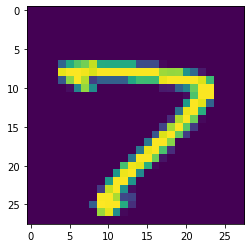

In [ ]:
plt.imshow(X_train[5000].reshape(28,28))

In [ ]:
X = torch.tensor(X_train[5000], dtype=torch.float)
X = X.to(device)
Q, Z = decoupled_const_NPV_model_with_NPF_bias(X)
print(Q)

tensor([  4.3404,  -7.9216,   9.0490,   0.5681, -20.5055, -10.3604, -21.0346,
         26.9622,  -9.9846,  -2.3571], grad_fn=<SqueezeBackward3>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
1 - spatial.distance.cosine(Q.cpu().detach().numpy(), outputs_path)

0.9999999959825265

Experiments on Train data

5 samples

In [ ]:
accuracy_path, outputs_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:5], torch.tensor(Y_train[:5]))
print()
print("Accuracy:", accuracy_path)
print("Output shape:", outputs_path.shape)

Predictions
(5, 10)

Class label
torch.Size([5, 1])
tensor([[8],
        [8],
        [3],
        [0],
        [4]])

Accuracy
tensor(5)
5

Accuracy: tensor(1.)
Output shape: (5, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
X = torch.tensor(X_train[:5], dtype=torch.float)
X = X.to(device)
# print(X.is_cuda)
Q, Z = decoupled_const_NPV_model_with_NPF_bias(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
pred = Z.data.max(1, keepdim=True)[1]
print(pred)
correct = 0
correct += pred.eq(torch.tensor(Y_train[:5]).data.view_as(pred)).long().cpu().sum()
print("Correct: ", correct)

tensor([[8],
        [8],
        [3],
        [0],
        [4]])
Correct:  tensor(5)


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_path)

0.9999999754589928

10000 samples

In [ ]:
accuracy_path, outputs_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print()
print("Accuracy:", accuracy_path)
print("Output shape:", outputs_path.shape)


Accuracy: tensor(0.9989)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [42]:
X = torch.tensor(X_train[:10000], dtype=torch.float)
X = X.to(device)
# print(X.is_cuda)
Q, Z = decoupled_const_NPV_model_with_NPF_bias(X)
pred = Z.data.max(1, keepdim=True)[1]
correct = 0
correct += pred.eq(torch.tensor(Y_train[:10000]).data.view_as(pred)).long().cpu().sum()
accuracy = correct/10000
print("Accuracy: ", accuracy)

Accuracy:  tensor(0.9988)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_path)

0.9999999771664545

In [ ]:
X = torch.tensor(X_train, dtype=torch.float)
X = X.to(device)
# print(X.is_cuda)
Q_all, Z_all = decoupled_const_NPV_model_with_NPF_bias(X)
pred_all = Z_all.data.max(1, keepdim=True)[1]
correct_all = 0
correct_all += pred_all.eq(torch.tensor(Y_train).data.view_as(pred_all)).long().cpu().sum()
accuracy_all = correct_all/len(X_train)
print("Accuracy: ", accuracy_all)

Accuracy:  tensor(0.9992)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1. Static Path model

Top 50000 path model

In [ ]:
accuracy_50000_path, outputs_50000_path = get_path_truncation_outputs(sorted_keys[:50000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print("Accuracy:", accuracy_50000_path)
print("Output shape:", outputs_50000_path.shape)

Predictions
(10000, 10)

Class label
torch.Size([10000, 1])

Accuracy
tensor(9441)
10000
Accuracy: tensor(0.9441)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_50000_path)

0.9277320479076486

Top 40000 path model

In [ ]:
accuracy_40000_path, outputs_40000_path = get_path_truncation_outputs(sorted_keys[:40000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print("Accuracy:", accuracy_40000_path)
print("Output shape:", outputs_40000_path.shape)

Predictions
(10000, 10)

Class label
torch.Size([10000, 1])

Accuracy
tensor(9246)
10000
tensor(0.9246)
(10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_40000_path)

0.9134843122604787

Top 30000 path model

In [ ]:
accuracy_30000_path, outputs_30000_path = get_path_truncation_outputs(sorted_keys[:30000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print(accuracy_30000_path)
print(outputs_30000_path.shape)

Predictions
(10000, 10)

Class label
torch.Size([10000, 1])

Accuracy
tensor(9125)
10000
tensor(0.9125)
(10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_30000_path)

0.9032808549468662

In [ ]:
accuracy_30000_path, outputs_30000_path = get_path_truncation_outputs(sorted_keys[:30000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train, torch.tensor(Y_train))
print(accuracy_30000_path)
print(outputs_30000_path.shape)

tensor(0.9136)
(60000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q_all.cpu().detach().numpy(), outputs_30000_path)

0.9038435017961559

Top 20000 path

In [ ]:
accuracy_20000_path, outputs_20000_path = get_path_truncation_outputs(sorted_keys[:20000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print(accuracy_20000_path)
print(outputs_20000_path.shape)

tensor(0.8716)
(10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_20000_path)

0.8679271438107767

In [ ]:
accuracy_20000_path, outputs_20000_path = get_path_truncation_outputs(sorted_keys[:20000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train, torch.tensor(Y_train))
print(accuracy_20000_path)
print(outputs_20000_path.shape)

tensor(0.8698)
(60000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q_all.cpu().detach().numpy(), outputs_20000_path)

0.8683522177779238

Top 10000 path model

In [ ]:
accuracy_10000_path, outputs_10000_path = get_path_truncation_outputs(sorted_keys[:10000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]))
print(accuracy_10000_path)
print(outputs_10000_path.shape)

tensor(0.6978)
(10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_10000_path)

0.7823229509658117

Top 1000 Path model

In [ ]:
accuracy_1000_path, outputs_1000_path = get_path_truncation_outputs(sorted_keys[:1000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_train, torch.tensor(Y_train))
print(accuracy_1000_path)
print(outputs_1000_path.shape)

tensor(0.3470)
(60000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q_all.cpu().detach().numpy(), outputs_1000_path)

0.4253383166695307

Top 100 Path model

In [43]:
accuracy_100_path, outputs_100_path = get_path_truncation_outputs(sorted_keys[:100], path_vectors, NPF_effective_weights, NPF_effective_biases, 
                                                                  X_train[:10000], torch.tensor(Y_train[:10000]))
print(accuracy_100_path)
print(outputs_100_path.shape)

tensor(0.2154)
(10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [44]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_100_path)

0.15584799857066028

2. Dynamic Path model

Top 5000 path(active)

In [ ]:
accuracy_5000_active_path, outputs_5000_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]), n=5000, threshold=0.5)
print(accuracy_5000_active_path)
print(outputs_5000_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
avg_cosine_similarity(Q_all.cpu().detach().numpy(), outputs_5000_active_path)

Top 1000 path(active)

In [ ]:
accuracy_1000_active_path, outputs_1000_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, X_train[:10000], torch.tensor(Y_train[:10000]), n=1000, threshold=0.5)
print(accuracy_1000_active_path)
print(outputs_1000_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.5883)
(10000, 10)


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_1000_active_path)

0.6532919710705903

Top 100 path(active)

In [45]:
accuracy_100_active_path, outputs_100_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, 
                                                                                X_train[:10000], torch.tensor(Y_train[:10000]), n=100, threshold=0.5)
print(accuracy_100_active_path)
print(outputs_100_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.3106)
(10000, 10)


In [46]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_100_active_path)

0.3937876623873906

Experiments on Validation data

In [23]:
X_val, Y_val = get_dataset(validation_loader)
print(X_val.shape, Y_val.shape)

(10000, 784) (10000,)


Verifying pathwise decomposition model

In [ ]:
accuracy_path, outputs_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print()
print("Accuracy:", accuracy_path)
print("Output shape:", outputs_path.shape)


Accuracy: tensor(0.9711)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [24]:
X = torch.tensor(X_val, dtype=torch.float)
X = X.to(device)
# print(X.is_cuda)
Q, Z = decoupled_const_NPV_model_with_NPF_bias(X)
pred = Z.data.max(1, keepdim=True)[1]
correct = 0
correct += pred.eq(torch.tensor(Y_val).data.view_as(pred)).long().cpu().sum()
accuracy = correct/10000
print("Accuracy: ", accuracy)

Accuracy:  tensor(0.9711)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_path)

0.9999999772641378

1. Static path model

Top 50000 paths

In [ ]:
accuracy_50000_path, outputs_50000_path = get_path_truncation_outputs(sorted_keys[:50000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_50000_path)
print("Output shape:", outputs_50000_path.shape)

Accuracy: tensor(0.9199)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_50000_path)

0.9288854159179879

Top 40000 path

In [ ]:
accuracy_40000_path, outputs_40000_path = get_path_truncation_outputs(sorted_keys[:40000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_40000_path)
print("Output shape:", outputs_40000_path.shape)

Accuracy: tensor(0.9093)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_40000_path)

0.9147796035451438

Top 30000 path

In [ ]:
accuracy_30000_path, outputs_30000_path = get_path_truncation_outputs(sorted_keys[:30000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_30000_path)
print("Output shape:", outputs_30000_path.shape)

Accuracy: tensor(0.8988)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_30000_path)

0.9047412166220834

Top 20000 path

In [25]:
accuracy_20000_path, outputs_20000_path = get_path_truncation_outputs(sorted_keys[:20000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_20000_path)
print("Output shape:", outputs_20000_path.shape)

Accuracy: tensor(0.8552)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [29]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_20000_path)

0.8692107290759821

Top 10000 path

In [30]:
accuracy_10000_path, outputs_10000_path = get_path_truncation_outputs(sorted_keys[:10000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_10000_path)
print("Output shape:", outputs_10000_path.shape)

Accuracy: tensor(0.6845)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [31]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_10000_path)

0.782399761853499

Top 1000 path

In [32]:
accuracy_1000_path, outputs_1000_path = get_path_truncation_outputs(sorted_keys[:1000], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_1000_path)
print("Output shape:", outputs_1000_path.shape)

Accuracy: tensor(0.3498)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [36]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_1000_path)

0.42559251303239054

Top 100 path

In [34]:
accuracy_100_path, outputs_100_path = get_path_truncation_outputs(sorted_keys[:100], path_vectors, NPF_effective_weights, NPF_effective_biases, X_val, torch.tensor(Y_val))
print("Accuracy:", accuracy_100_path)
print("Output shape:", outputs_100_path.shape)

Accuracy: tensor(0.2177)
Output shape: (10000, 10)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [37]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_100_path)

0.15098197858255064

2. Dynamic Path model

Top 2500 active paths


In [ ]:
accuracy_2500_active_path, outputs_2500_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, 
                                                                                  X_val, torch.tensor(Y_val), n=2500, threshold=0.5)
print(accuracy_2500_active_path)
print(outputs_2500_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_2500_active_path)

Top 1000 active paths

In [ ]:
accuracy_1000_active_path, outputs_1000_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, 
                                                                                  X_val, torch.tensor(Y_val), n=1000, threshold=0.5)
print(accuracy_1000_active_path)
print(outputs_1000_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.5733)
(10000, 10)


In [ ]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_1000_active_path)

0.6550820888482858

Top 100 active paths

In [38]:
accuracy_100_active_path, outputs_100_active_path = get_path_truncation_outputs(sorted_keys, path_vectors, NPF_effective_weights, NPF_effective_biases, 
                                                                                  X_val, torch.tensor(Y_val), n=100, threshold=0.5)
print(accuracy_100_active_path)
print(outputs_100_active_path.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor(0.3167)
(10000, 10)


In [39]:
avg_cosine_similarity(Q.cpu().detach().numpy(), outputs_100_active_path)

0.39661604956420454